# Neural Contextual Bandits with UCB-based Exploration
Notation:

| Notation                 | Description                                                  |
| :----------------------- | :----------------------------------------------------------- |
| $K$                      | number of arms                                               |
| $T$                      | number of total rounds                                       |
| $t$                      | index of round                                               |
| $x_{t,a}$                | $x_{t,a}\in\mathbb{R}^d$, $a\in [K]$, it is the context, the context consists of $K$ feature vectors $\{x_{t,a}\in\mathbb{R}^d|a\in[K]\}$ |
| $a_t$                    | after observes the context, the agent select an action $a_t$ in round t |
| $r_{t,a_t}$              | the reward after the agent select action $a_t$               |
| $h$                      | we assume that $r_{t,a_t}=h(x_{t,a_t})+\xi_t$, h is an unknown function satisfying $0\le h(x)\le 1$ for any x |
| $\xi_t$                  | $\xi_t$ is v-sub-Gaussian noise conditioned on $x_{1,a_1},\cdots,x_{t-1,a_{t-1}}$, satisfying $\mathbb{E}\xi_t=0$ |
| $L$                      | the depth of neural network                                  |
| $m$                      | number of neural in each layer of network                    |
| $\sigma(x)$              | we define $\sigma(x)=\max\{x,0\}$                            |
| $W_1,\cdots,W_{L-1},W_L$ | the weight in neural network. $W_1\in\mathbb{R}^{m\times d}$, $W_i\in\mathbb{R}^{m\times m}$, $2\le i\le L-1$, $W_L\in\mathbb{R}^{m\times 1}$ |
| $\theta$                 | $\theta=[vec(W_1)^T,\cdots,vec(W_l)^T]\in\mathbb{R}^p$, $p=m+md+m^2(L-1)$ |
| $f(x;\theta)$            | we define $f(x;\theta)=\sqrt{m}W_L\sigma(W_{l-1}\sigma(\cdots\sigma(W_1x)))$ |


<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

Initialization of parameters:

<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Initialization2.png" style="zoom:80%" />

UCB algorithm:

<img src="./Figure/NeuralUCB_Algorithm1.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Algorithm2.png" style="zoom:80%" />

 We assume the reward follows reward = context^T * A^T * A * context + \xi
 
 $\xi$ is a random variable following standard normal distribution N(0, 1)
 
 A is d\*d matrix, randomly generated from N(0, 1)
 
 We assume the context is independent from the action and round index. 
 
 Given action a and round index t, the context is randomly sample from a unit ball in dimension d

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
type(device)

cuda:0


torch.device

In [1]:
%reset -f
import numpy as np
import random
from copy import deepcopy

from Source.agent import *
from Source.GameSetting import *

In [2]:
# Set the parameter of the game
np.random.seed(12345)
K = 4# Total number of actions, 
T = 5000 # Total number of periods
d = 4 # the dimension of context
A = np.random.normal(loc=0, scale=1, size=(d, d))

In [4]:
# Implement the algorithm
np.random.seed(12345)

# Set the parameter of the network
# the setting is based on the description of section 7.1 of the papaer
L = 2
m = 30 
# we fix gamma in each round, according to the description of section 3.1
gamma_t = 0.01 #{0.01, 0.1, 1, 10}
nu = 0.1 #{0.01, 0.1, 1}
lambda_ = 1 #{0.1, 1, 10}
delta = 0.01 #{0.01, 0.1, 1}
S = 0.01 #{0.01, 0.1, 1, 10}
eta = 1e-3 #{0.001, 0.01, 0.1}
frequency = 50
batchsize = 50
verbose = False
# we set J equal to round index t

neuralagent = NeuralAgent(
    K=K, T=T, d=d, L=L, m=m, gamma_t=gamma_t, nu=nu, lambda_=lambda_, delta=delta, S=S, eta=eta, frequency=frequency, batchsize=batchsize
)
bestagent = BestAgent(K, T, d, A)
uniformagent = UniformAgent(K, T, d)
for tt in range(1, T + 1):
    
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    realized_reward = GetRealReward(context_list, A)
    
    # neuralagent
    neural_ind = neuralagent.Action(context_list)# make a decision
    neural_reward = realized_reward[neural_ind]# play neural_ind-th arm and observe reward
    neuralagent.Update(neural_reward)
    
    # bestagent
    best_ind = bestagent.Action(context_list)# make a decision
    best_reward = realized_reward[best_ind]# play best_ind-th arm and observe reward
    bestagent.Update(best_reward)
    
    # uniformagent
    uniform_ind = uniformagent.Action(context_list)# make a decision
    uniform_reward = realized_reward[uniform_ind]# play uniform_ind-th arm and observe reward
    uniformagent.Update(uniform_reward)
    
    print("round index {:d}; neural choose {:d}, reward is {:f}; best choose {:d}, reward is {:f}".format(tt,
                                                                                                          neural_ind,
                                                                                                          neural_reward,
                                                                                                          best_ind,
                                                                                                          best_reward,))

Using device cuda:0
round index 1; neural choose 3, reward is 6.666776; best choose 3, reward is 6.666776
round index 2; neural choose 3, reward is 5.186151; best choose 2, reward is 5.908255
round index 3; neural choose 3, reward is 6.140475; best choose 0, reward is 6.648616
round index 4; neural choose 3, reward is 6.597986; best choose 2, reward is 6.691268
round index 5; neural choose 3, reward is 3.298056; best choose 0, reward is 4.934174
round index 6; neural choose 3, reward is 5.176071; best choose 1, reward is 6.128102
round index 7; neural choose 2, reward is 6.796975; best choose 2, reward is 6.796975
round index 8; neural choose 2, reward is 3.449769; best choose 3, reward is 6.706144
round index 9; neural choose 1, reward is 0.587056; best choose 3, reward is 6.086979
round index 10; neural choose 2, reward is 1.360722; best choose 1, reward is 6.629483
round index 11; neural choose 3, reward is 1.822996; best choose 2, reward is 5.535969
round index 12; neural choose 3,

20 training epoch, mean loss value is 2.7951700199601213
40 training epoch, mean loss value is 1.8788510955181077
60 training epoch, mean loss value is 1.1450457771622746
80 training epoch, mean loss value is 0.6296355267886296
round index 100; neural choose 0, reward is 6.694083; best choose 0, reward is 6.694083
round index 101; neural choose 0, reward is 6.669224; best choose 0, reward is 6.669224
round index 102; neural choose 0, reward is 6.603807; best choose 0, reward is 6.603807
round index 103; neural choose 2, reward is 6.462672; best choose 2, reward is 6.462672
round index 104; neural choose 0, reward is 6.657085; best choose 0, reward is 6.657085
round index 105; neural choose 2, reward is 6.774117; best choose 2, reward is 6.774117
round index 106; neural choose 1, reward is 6.531400; best choose 1, reward is 6.531400
round index 107; neural choose 3, reward is 4.734054; best choose 3, reward is 4.734054
round index 108; neural choose 2, reward is 5.255825; best choose 2,

round index 188; neural choose 2, reward is 2.397106; best choose 2, reward is 2.397106
round index 189; neural choose 2, reward is 5.399444; best choose 2, reward is 5.399444
round index 190; neural choose 2, reward is 5.168959; best choose 2, reward is 5.168959
round index 191; neural choose 1, reward is 2.946425; best choose 1, reward is 2.946425
round index 192; neural choose 3, reward is 6.774760; best choose 3, reward is 6.774760
round index 193; neural choose 1, reward is 6.301182; best choose 3, reward is 6.361263
round index 194; neural choose 3, reward is 6.344538; best choose 3, reward is 6.344538
round index 195; neural choose 1, reward is 4.961500; best choose 1, reward is 4.961500
round index 196; neural choose 2, reward is 5.971035; best choose 2, reward is 5.971035
round index 197; neural choose 0, reward is 6.740215; best choose 0, reward is 6.740215
round index 198; neural choose 1, reward is 6.752042; best choose 1, reward is 6.752042
round index 199; neural choose 0

round index 290; neural choose 0, reward is 6.386239; best choose 0, reward is 6.386239
round index 291; neural choose 2, reward is 6.693003; best choose 3, reward is 6.733564
round index 292; neural choose 1, reward is 3.982920; best choose 1, reward is 3.982920
round index 293; neural choose 3, reward is 6.712021; best choose 3, reward is 6.712021
round index 294; neural choose 1, reward is 6.615328; best choose 1, reward is 6.615328
round index 295; neural choose 2, reward is 6.757129; best choose 2, reward is 6.757129
round index 296; neural choose 0, reward is 6.652185; best choose 0, reward is 6.652185
round index 297; neural choose 1, reward is 5.322310; best choose 1, reward is 5.322310
round index 298; neural choose 3, reward is 6.596527; best choose 3, reward is 6.596527
round index 299; neural choose 1, reward is 6.233742; best choose 1, reward is 6.233742
20 training epoch, mean loss value is 0.004638749413771788
40 training epoch, mean loss value is 0.004452628727832858
60

round index 384; neural choose 3, reward is 6.346686; best choose 3, reward is 6.346686
round index 385; neural choose 0, reward is 6.280955; best choose 0, reward is 6.280955
round index 386; neural choose 3, reward is 6.421365; best choose 3, reward is 6.421365
round index 387; neural choose 3, reward is 6.699318; best choose 3, reward is 6.699318
round index 388; neural choose 2, reward is 6.797353; best choose 2, reward is 6.797353
round index 389; neural choose 0, reward is 6.549209; best choose 0, reward is 6.549209
round index 390; neural choose 1, reward is 6.005693; best choose 1, reward is 6.005693
round index 391; neural choose 3, reward is 4.846505; best choose 3, reward is 4.846505
round index 392; neural choose 0, reward is 5.376315; best choose 0, reward is 5.376315
round index 393; neural choose 2, reward is 6.744239; best choose 2, reward is 6.744239
round index 394; neural choose 1, reward is 6.713712; best choose 1, reward is 6.713712
round index 395; neural choose 0

round index 489; neural choose 3, reward is 6.817871; best choose 3, reward is 6.817871
round index 490; neural choose 0, reward is 6.730842; best choose 0, reward is 6.730842
round index 491; neural choose 0, reward is 6.156511; best choose 0, reward is 6.156511
round index 492; neural choose 0, reward is 6.809493; best choose 0, reward is 6.809493
round index 493; neural choose 1, reward is 6.686991; best choose 1, reward is 6.686991
round index 494; neural choose 0, reward is 6.156079; best choose 0, reward is 6.156079
round index 495; neural choose 0, reward is 6.584081; best choose 0, reward is 6.584081
round index 496; neural choose 3, reward is 6.730936; best choose 3, reward is 6.730936
round index 497; neural choose 1, reward is 6.770664; best choose 1, reward is 6.770664
round index 498; neural choose 1, reward is 6.764105; best choose 1, reward is 6.764105
round index 499; neural choose 1, reward is 5.503072; best choose 1, reward is 5.503072
20 training epoch, mean loss val

round index 590; neural choose 0, reward is 6.740512; best choose 0, reward is 6.740512
round index 591; neural choose 3, reward is 6.561024; best choose 3, reward is 6.561024
round index 592; neural choose 2, reward is 6.554106; best choose 2, reward is 6.554106
round index 593; neural choose 1, reward is 6.532813; best choose 1, reward is 6.532813
round index 594; neural choose 0, reward is 6.657585; best choose 0, reward is 6.657585
round index 595; neural choose 1, reward is 6.546919; best choose 1, reward is 6.546919
round index 596; neural choose 2, reward is 2.475673; best choose 2, reward is 2.475673
round index 597; neural choose 3, reward is 6.570156; best choose 3, reward is 6.570156
round index 598; neural choose 2, reward is 6.789723; best choose 2, reward is 6.789723
round index 599; neural choose 1, reward is 6.603739; best choose 1, reward is 6.603739
20 training epoch, mean loss value is 0.0027976470143933527
40 training epoch, mean loss value is 0.00278937327743186
60

round index 689; neural choose 2, reward is 5.486810; best choose 2, reward is 5.486810
round index 690; neural choose 3, reward is 6.835792; best choose 3, reward is 6.835792
round index 691; neural choose 1, reward is 6.577221; best choose 1, reward is 6.577221
round index 692; neural choose 1, reward is 6.072672; best choose 1, reward is 6.072672
round index 693; neural choose 2, reward is 6.096203; best choose 2, reward is 6.096203
round index 694; neural choose 1, reward is 5.651628; best choose 1, reward is 5.651628
round index 695; neural choose 2, reward is 6.428984; best choose 2, reward is 6.428984
round index 696; neural choose 0, reward is 6.599552; best choose 0, reward is 6.599552
round index 697; neural choose 1, reward is 4.137044; best choose 1, reward is 4.137044
round index 698; neural choose 1, reward is 5.904780; best choose 1, reward is 5.904780
round index 699; neural choose 0, reward is 5.915165; best choose 0, reward is 5.915165
20 training epoch, mean loss val

round index 786; neural choose 2, reward is 6.533174; best choose 2, reward is 6.533174
round index 787; neural choose 1, reward is 6.290035; best choose 1, reward is 6.290035
round index 788; neural choose 1, reward is 6.698949; best choose 1, reward is 6.698949
round index 789; neural choose 3, reward is 5.060059; best choose 3, reward is 5.060059
round index 790; neural choose 1, reward is 6.624450; best choose 1, reward is 6.624450
round index 791; neural choose 1, reward is 6.184478; best choose 1, reward is 6.184478
round index 792; neural choose 0, reward is 6.633335; best choose 0, reward is 6.633335
round index 793; neural choose 0, reward is 6.178100; best choose 0, reward is 6.178100
round index 794; neural choose 2, reward is 6.717678; best choose 2, reward is 6.717678
round index 795; neural choose 2, reward is 6.122952; best choose 2, reward is 6.122952
round index 796; neural choose 1, reward is 6.703361; best choose 1, reward is 6.703361
round index 797; neural choose 1

round index 884; neural choose 3, reward is 6.761893; best choose 3, reward is 6.761893
round index 885; neural choose 0, reward is 5.547610; best choose 0, reward is 5.547610
round index 886; neural choose 2, reward is 6.664209; best choose 2, reward is 6.664209
round index 887; neural choose 0, reward is 6.353189; best choose 0, reward is 6.353189
round index 888; neural choose 2, reward is 4.478635; best choose 2, reward is 4.478635
round index 889; neural choose 3, reward is 4.718381; best choose 3, reward is 4.718381
round index 890; neural choose 3, reward is 6.616172; best choose 3, reward is 6.616172
round index 891; neural choose 1, reward is 6.701939; best choose 1, reward is 6.701939
round index 892; neural choose 1, reward is 6.746762; best choose 1, reward is 6.746762
round index 893; neural choose 0, reward is 6.667227; best choose 0, reward is 6.667227
round index 894; neural choose 0, reward is 6.789547; best choose 0, reward is 6.789547
round index 895; neural choose 2

round index 989; neural choose 2, reward is 6.368433; best choose 2, reward is 6.368433
round index 990; neural choose 0, reward is 6.512141; best choose 0, reward is 6.512141
round index 991; neural choose 1, reward is 6.757057; best choose 1, reward is 6.757057
round index 992; neural choose 1, reward is 6.710216; best choose 1, reward is 6.710216
round index 993; neural choose 0, reward is 6.525295; best choose 0, reward is 6.525295
round index 994; neural choose 3, reward is 1.606687; best choose 3, reward is 1.606687
round index 995; neural choose 2, reward is 6.028674; best choose 2, reward is 6.028674
round index 996; neural choose 0, reward is 6.760254; best choose 0, reward is 6.760254
round index 997; neural choose 0, reward is 6.568689; best choose 0, reward is 6.568689
round index 998; neural choose 3, reward is 6.759462; best choose 3, reward is 6.759462
round index 999; neural choose 3, reward is 6.305411; best choose 3, reward is 6.305411
20 training epoch, mean loss val

round index 1089; neural choose 3, reward is 4.440869; best choose 3, reward is 4.440869
round index 1090; neural choose 3, reward is 6.253440; best choose 3, reward is 6.253440
round index 1091; neural choose 0, reward is 5.828390; best choose 0, reward is 5.828390
round index 1092; neural choose 2, reward is 6.688595; best choose 2, reward is 6.688595
round index 1093; neural choose 2, reward is 6.452525; best choose 2, reward is 6.452525
round index 1094; neural choose 2, reward is 6.553664; best choose 2, reward is 6.553664
round index 1095; neural choose 3, reward is 4.670247; best choose 3, reward is 4.670247
round index 1096; neural choose 3, reward is 6.174880; best choose 3, reward is 6.174880
round index 1097; neural choose 3, reward is 6.732323; best choose 0, reward is 6.807895
round index 1098; neural choose 2, reward is 6.617792; best choose 2, reward is 6.617792
round index 1099; neural choose 0, reward is 6.266254; best choose 0, reward is 6.266254
20 training epoch, me

round index 1191; neural choose 3, reward is 6.725353; best choose 3, reward is 6.725353
round index 1192; neural choose 1, reward is 3.956909; best choose 1, reward is 3.956909
round index 1193; neural choose 0, reward is 4.214344; best choose 0, reward is 4.214344
round index 1194; neural choose 2, reward is 6.346622; best choose 2, reward is 6.346622
round index 1195; neural choose 0, reward is 3.664474; best choose 0, reward is 3.664474
round index 1196; neural choose 2, reward is 6.333868; best choose 2, reward is 6.333868
round index 1197; neural choose 0, reward is 5.208160; best choose 0, reward is 5.208160
round index 1198; neural choose 0, reward is 6.608403; best choose 0, reward is 6.608403
round index 1199; neural choose 2, reward is 5.461504; best choose 2, reward is 5.461504
20 training epoch, mean loss value is 0.0026113913881284628
40 training epoch, mean loss value is 0.0026103712492439673
60 training epoch, mean loss value is 0.0026093601675441793
80 training epoch, 

round index 1288; neural choose 1, reward is 6.608733; best choose 1, reward is 6.608733
round index 1289; neural choose 1, reward is 6.206132; best choose 1, reward is 6.206132
round index 1290; neural choose 1, reward is 4.981976; best choose 1, reward is 4.981976
round index 1291; neural choose 3, reward is 6.630372; best choose 2, reward is 6.642810
round index 1292; neural choose 2, reward is 6.201104; best choose 2, reward is 6.201104
round index 1293; neural choose 0, reward is 6.769053; best choose 0, reward is 6.769053
round index 1294; neural choose 0, reward is 1.884878; best choose 0, reward is 1.884878
round index 1295; neural choose 3, reward is 6.760375; best choose 3, reward is 6.760375
round index 1296; neural choose 3, reward is 6.707689; best choose 3, reward is 6.707689
round index 1297; neural choose 1, reward is 6.665991; best choose 1, reward is 6.665991
round index 1298; neural choose 2, reward is 5.210501; best choose 2, reward is 5.210501
round index 1299; neu

round index 1391; neural choose 1, reward is 5.301077; best choose 1, reward is 5.301077
round index 1392; neural choose 2, reward is 6.553002; best choose 2, reward is 6.553002
round index 1393; neural choose 3, reward is 6.448486; best choose 3, reward is 6.448486
round index 1394; neural choose 0, reward is 6.458554; best choose 0, reward is 6.458554
round index 1395; neural choose 2, reward is 6.694281; best choose 2, reward is 6.694281
round index 1396; neural choose 0, reward is 5.929249; best choose 0, reward is 5.929249
round index 1397; neural choose 2, reward is 6.689635; best choose 2, reward is 6.689635
round index 1398; neural choose 3, reward is 6.773220; best choose 3, reward is 6.773220
round index 1399; neural choose 3, reward is 6.726175; best choose 3, reward is 6.726175
20 training epoch, mean loss value is 0.0026911695256976627
40 training epoch, mean loss value is 0.0026903373905029673
60 training epoch, mean loss value is 0.0026895519292019694
80 training epoch, 

round index 1489; neural choose 3, reward is 6.675900; best choose 3, reward is 6.675900
round index 1490; neural choose 0, reward is 6.531064; best choose 0, reward is 6.531064
round index 1491; neural choose 3, reward is 6.734239; best choose 3, reward is 6.734239
round index 1492; neural choose 1, reward is 6.443292; best choose 1, reward is 6.443292
round index 1493; neural choose 3, reward is 5.434533; best choose 3, reward is 5.434533
round index 1494; neural choose 2, reward is 6.644538; best choose 2, reward is 6.644538
round index 1495; neural choose 2, reward is 6.590768; best choose 2, reward is 6.590768
round index 1496; neural choose 0, reward is 6.588145; best choose 0, reward is 6.588145
round index 1497; neural choose 1, reward is 6.130190; best choose 1, reward is 6.130190
round index 1498; neural choose 1, reward is 6.210930; best choose 1, reward is 6.210930
round index 1499; neural choose 3, reward is 6.415966; best choose 3, reward is 6.415966
20 training epoch, me

round index 1591; neural choose 1, reward is 2.930290; best choose 1, reward is 2.930290
round index 1592; neural choose 0, reward is 6.575293; best choose 0, reward is 6.575293
round index 1593; neural choose 1, reward is 6.726662; best choose 1, reward is 6.726662
round index 1594; neural choose 3, reward is 6.008192; best choose 3, reward is 6.008192
round index 1595; neural choose 0, reward is 3.908039; best choose 0, reward is 3.908039
round index 1596; neural choose 3, reward is 5.795939; best choose 3, reward is 5.795939
round index 1597; neural choose 2, reward is 6.457649; best choose 2, reward is 6.457649
round index 1598; neural choose 0, reward is 6.666049; best choose 0, reward is 6.666049
round index 1599; neural choose 0, reward is 3.822514; best choose 0, reward is 3.822514
20 training epoch, mean loss value is 0.0026311500547537546
40 training epoch, mean loss value is 0.002630535966896773
60 training epoch, mean loss value is 0.002629995786314304
80 training epoch, me

round index 1691; neural choose 3, reward is 6.148176; best choose 3, reward is 6.148176
round index 1692; neural choose 2, reward is 6.479528; best choose 2, reward is 6.479528
round index 1693; neural choose 2, reward is 6.686346; best choose 2, reward is 6.686346
round index 1694; neural choose 2, reward is 6.666743; best choose 2, reward is 6.666743
round index 1695; neural choose 0, reward is 6.054956; best choose 0, reward is 6.054956
round index 1696; neural choose 0, reward is 6.400039; best choose 0, reward is 6.400039
round index 1697; neural choose 0, reward is 6.755590; best choose 0, reward is 6.755590
round index 1698; neural choose 2, reward is 3.463860; best choose 2, reward is 3.463860
round index 1699; neural choose 1, reward is 6.007320; best choose 1, reward is 6.007320
20 training epoch, mean loss value is 0.0026232139419331245
40 training epoch, mean loss value is 0.002622758125222284
60 training epoch, mean loss value is 0.0026222886144770265
80 training epoch, m

round index 1790; neural choose 2, reward is 6.564881; best choose 2, reward is 6.564881
round index 1791; neural choose 0, reward is 2.909353; best choose 0, reward is 2.909353
round index 1792; neural choose 0, reward is 6.650140; best choose 0, reward is 6.650140
round index 1793; neural choose 2, reward is 6.615197; best choose 2, reward is 6.615197
round index 1794; neural choose 3, reward is 5.431003; best choose 3, reward is 5.431003
round index 1795; neural choose 3, reward is 6.705131; best choose 3, reward is 6.705131
round index 1796; neural choose 1, reward is 6.181055; best choose 1, reward is 6.181055
round index 1797; neural choose 1, reward is 6.280678; best choose 1, reward is 6.280678
round index 1798; neural choose 2, reward is 5.871687; best choose 2, reward is 5.871687
round index 1799; neural choose 2, reward is 6.776033; best choose 2, reward is 6.776033
20 training epoch, mean loss value is 0.002618886582811609
40 training epoch, mean loss value is 0.00261825633

round index 1889; neural choose 1, reward is 2.801493; best choose 1, reward is 2.801493
round index 1890; neural choose 1, reward is 6.437874; best choose 1, reward is 6.437874
round index 1891; neural choose 2, reward is 6.417534; best choose 2, reward is 6.417534
round index 1892; neural choose 3, reward is 6.196710; best choose 3, reward is 6.196710
round index 1893; neural choose 2, reward is 6.637100; best choose 2, reward is 6.637100
round index 1894; neural choose 3, reward is 6.741808; best choose 3, reward is 6.741808
round index 1895; neural choose 3, reward is 6.029737; best choose 3, reward is 6.029737
round index 1896; neural choose 0, reward is 6.441683; best choose 0, reward is 6.441683
round index 1897; neural choose 0, reward is 5.854821; best choose 0, reward is 5.854821
round index 1898; neural choose 1, reward is 6.702943; best choose 1, reward is 6.702943
round index 1899; neural choose 3, reward is 6.625177; best choose 3, reward is 6.625177
20 training epoch, me

round index 1991; neural choose 1, reward is 6.614827; best choose 1, reward is 6.614827
round index 1992; neural choose 1, reward is 6.783452; best choose 1, reward is 6.783452
round index 1993; neural choose 0, reward is 6.491520; best choose 0, reward is 6.491520
round index 1994; neural choose 3, reward is 6.822483; best choose 3, reward is 6.822483
round index 1995; neural choose 3, reward is 6.180208; best choose 3, reward is 6.180208
round index 1996; neural choose 2, reward is 5.538120; best choose 2, reward is 5.538120
round index 1997; neural choose 1, reward is 5.682344; best choose 1, reward is 5.682344
round index 1998; neural choose 2, reward is 4.702105; best choose 2, reward is 4.702105
round index 1999; neural choose 3, reward is 6.610230; best choose 3, reward is 6.610230
20 training epoch, mean loss value is 0.002614056265772175
40 training epoch, mean loss value is 0.0026131939857733603
60 training epoch, mean loss value is 0.002612249812877191
80 training epoch, me

round index 2088; neural choose 3, reward is 6.788214; best choose 3, reward is 6.788214
round index 2089; neural choose 0, reward is 5.455191; best choose 0, reward is 5.455191
round index 2090; neural choose 3, reward is 3.708089; best choose 3, reward is 3.708089
round index 2091; neural choose 1, reward is 6.454039; best choose 1, reward is 6.454039
round index 2092; neural choose 0, reward is 4.334741; best choose 0, reward is 4.334741
round index 2093; neural choose 2, reward is 5.407149; best choose 2, reward is 5.407149
round index 2094; neural choose 1, reward is 5.043683; best choose 1, reward is 5.043683
round index 2095; neural choose 2, reward is 6.219316; best choose 2, reward is 6.219316
round index 2096; neural choose 2, reward is 6.733834; best choose 2, reward is 6.733834
round index 2097; neural choose 1, reward is 6.705108; best choose 1, reward is 6.705108
round index 2098; neural choose 1, reward is 5.763044; best choose 1, reward is 5.763044
round index 2099; neu

round index 2190; neural choose 1, reward is 6.662698; best choose 1, reward is 6.662698
round index 2191; neural choose 0, reward is 6.281476; best choose 0, reward is 6.281476
round index 2192; neural choose 1, reward is 6.625558; best choose 1, reward is 6.625558
round index 2193; neural choose 3, reward is 6.538146; best choose 3, reward is 6.538146
round index 2194; neural choose 1, reward is 4.742254; best choose 1, reward is 4.742254
round index 2195; neural choose 3, reward is 6.633496; best choose 3, reward is 6.633496
round index 2196; neural choose 2, reward is 5.580965; best choose 2, reward is 5.580965
round index 2197; neural choose 0, reward is 6.410504; best choose 0, reward is 6.410504
round index 2198; neural choose 3, reward is 6.471960; best choose 3, reward is 6.471960
round index 2199; neural choose 0, reward is 4.904726; best choose 0, reward is 4.904726
20 training epoch, mean loss value is 0.0026229960966803645
40 training epoch, mean loss value is 0.0026220538

round index 2290; neural choose 0, reward is 6.244034; best choose 0, reward is 6.244034
round index 2291; neural choose 3, reward is 6.018532; best choose 3, reward is 6.018532
round index 2292; neural choose 3, reward is 5.689335; best choose 3, reward is 5.689335
round index 2293; neural choose 0, reward is 6.619844; best choose 0, reward is 6.619844
round index 2294; neural choose 1, reward is 3.986250; best choose 1, reward is 3.986250
round index 2295; neural choose 2, reward is 6.798693; best choose 2, reward is 6.798693
round index 2296; neural choose 3, reward is 6.667490; best choose 3, reward is 6.667490
round index 2297; neural choose 0, reward is 2.601499; best choose 0, reward is 2.601499
round index 2298; neural choose 2, reward is 6.166030; best choose 2, reward is 6.166030
round index 2299; neural choose 2, reward is 3.008525; best choose 2, reward is 3.008525
20 training epoch, mean loss value is 0.0025813408268905353
40 training epoch, mean loss value is 0.0025810324

round index 2389; neural choose 2, reward is 6.693929; best choose 2, reward is 6.693929
round index 2390; neural choose 1, reward is 6.750622; best choose 1, reward is 6.750622
round index 2391; neural choose 1, reward is 2.938133; best choose 1, reward is 2.938133
round index 2392; neural choose 3, reward is 6.735132; best choose 3, reward is 6.735132
round index 2393; neural choose 2, reward is 6.671294; best choose 2, reward is 6.671294
round index 2394; neural choose 2, reward is 6.709409; best choose 2, reward is 6.709409
round index 2395; neural choose 1, reward is 6.804397; best choose 1, reward is 6.804397
round index 2396; neural choose 1, reward is 6.720037; best choose 1, reward is 6.720037
round index 2397; neural choose 3, reward is 6.706327; best choose 3, reward is 6.706327
round index 2398; neural choose 2, reward is 1.285729; best choose 2, reward is 1.285729
round index 2399; neural choose 0, reward is 6.532754; best choose 0, reward is 6.532754
20 training epoch, me

round index 2492; neural choose 1, reward is 4.700988; best choose 1, reward is 4.700988
round index 2493; neural choose 3, reward is 6.722898; best choose 3, reward is 6.722898
round index 2494; neural choose 2, reward is 5.310138; best choose 2, reward is 5.310138
round index 2495; neural choose 0, reward is 6.749482; best choose 0, reward is 6.749482
round index 2496; neural choose 1, reward is 6.601980; best choose 1, reward is 6.601980
round index 2497; neural choose 0, reward is 5.932566; best choose 0, reward is 5.932566
round index 2498; neural choose 0, reward is 6.562484; best choose 0, reward is 6.562484
round index 2499; neural choose 3, reward is 3.855295; best choose 3, reward is 3.855295
20 training epoch, mean loss value is 0.0025906720136843974
40 training epoch, mean loss value is 0.0025902168261242196
60 training epoch, mean loss value is 0.0025898505880450774
80 training epoch, mean loss value is 0.002589514008385306
100 training epoch, mean loss value is 0.00258919

round index 2590; neural choose 1, reward is 6.367456; best choose 1, reward is 6.367456
round index 2591; neural choose 0, reward is 6.451161; best choose 0, reward is 6.451161
round index 2592; neural choose 3, reward is 6.572187; best choose 3, reward is 6.572187
round index 2593; neural choose 3, reward is 6.609364; best choose 3, reward is 6.609364
round index 2594; neural choose 2, reward is 6.337341; best choose 2, reward is 6.337341
round index 2595; neural choose 1, reward is 6.495735; best choose 1, reward is 6.495735
round index 2596; neural choose 1, reward is 6.350811; best choose 1, reward is 6.350811
round index 2597; neural choose 1, reward is 5.708767; best choose 1, reward is 5.708767
round index 2598; neural choose 0, reward is 6.747024; best choose 0, reward is 6.747024
round index 2599; neural choose 3, reward is 6.551624; best choose 3, reward is 6.551624
20 training epoch, mean loss value is 0.0025792418038160904
40 training epoch, mean loss value is 0.0025788152

round index 2691; neural choose 1, reward is 6.650177; best choose 1, reward is 6.650177
round index 2692; neural choose 0, reward is 6.395750; best choose 0, reward is 6.395750
round index 2693; neural choose 3, reward is 6.501066; best choose 3, reward is 6.501066
round index 2694; neural choose 0, reward is 6.715154; best choose 0, reward is 6.715154
round index 2695; neural choose 1, reward is 6.620157; best choose 1, reward is 6.620157
round index 2696; neural choose 1, reward is 6.647737; best choose 1, reward is 6.647737
round index 2697; neural choose 1, reward is 6.384529; best choose 1, reward is 6.384529
round index 2698; neural choose 2, reward is 5.141757; best choose 2, reward is 5.141757
round index 2699; neural choose 2, reward is 6.778480; best choose 2, reward is 6.778480
20 training epoch, mean loss value is 0.0025644054368808866
40 training epoch, mean loss value is 0.0025640233602964853
60 training epoch, mean loss value is 0.002563640711523743
80 training epoch, m

round index 2789; neural choose 2, reward is 6.846184; best choose 2, reward is 6.846184
round index 2790; neural choose 0, reward is 5.210497; best choose 0, reward is 5.210497
round index 2791; neural choose 3, reward is 4.799493; best choose 3, reward is 4.799493
round index 2792; neural choose 0, reward is 4.499579; best choose 0, reward is 4.499579
round index 2793; neural choose 1, reward is 6.607779; best choose 1, reward is 6.607779
round index 2794; neural choose 2, reward is 6.122720; best choose 2, reward is 6.122720
round index 2795; neural choose 2, reward is 6.687658; best choose 2, reward is 6.687658
round index 2796; neural choose 1, reward is 5.111258; best choose 1, reward is 5.111258
round index 2797; neural choose 0, reward is 4.429432; best choose 0, reward is 4.429432
round index 2798; neural choose 1, reward is 4.064059; best choose 1, reward is 4.064059
round index 2799; neural choose 3, reward is 4.766392; best choose 3, reward is 4.766392
20 training epoch, me

round index 2893; neural choose 3, reward is 6.340829; best choose 3, reward is 6.340829
round index 2894; neural choose 3, reward is 6.764697; best choose 3, reward is 6.764697
round index 2895; neural choose 2, reward is 6.222727; best choose 2, reward is 6.222727
round index 2896; neural choose 2, reward is 6.565850; best choose 2, reward is 6.565850
round index 2897; neural choose 2, reward is 6.366387; best choose 2, reward is 6.366387
round index 2898; neural choose 0, reward is 6.804366; best choose 0, reward is 6.804366
round index 2899; neural choose 2, reward is 6.496310; best choose 2, reward is 6.496310
20 training epoch, mean loss value is 0.0025678891565641994
40 training epoch, mean loss value is 0.0025670885757699776
60 training epoch, mean loss value is 0.0025663272953534095
80 training epoch, mean loss value is 0.0025655636300254306
100 training epoch, mean loss value is 0.002564906104230182
round index 2900; neural choose 1, reward is 6.594042; best choose 1, reward 

round index 2988; neural choose 0, reward is 6.698902; best choose 0, reward is 6.698902
round index 2989; neural choose 1, reward is 6.705418; best choose 1, reward is 6.705418
round index 2990; neural choose 3, reward is 6.490945; best choose 3, reward is 6.490945
round index 2991; neural choose 2, reward is 5.466921; best choose 2, reward is 5.466921
round index 2992; neural choose 0, reward is 5.570329; best choose 0, reward is 5.570329
round index 2993; neural choose 1, reward is 6.457689; best choose 1, reward is 6.457689
round index 2994; neural choose 3, reward is 6.636543; best choose 3, reward is 6.636543
round index 2995; neural choose 2, reward is 4.368538; best choose 2, reward is 4.368538
round index 2996; neural choose 3, reward is 6.368637; best choose 3, reward is 6.368637
round index 2997; neural choose 1, reward is 6.768470; best choose 1, reward is 6.768470
round index 2998; neural choose 0, reward is 5.960395; best choose 0, reward is 5.960395
round index 2999; neu

round index 3088; neural choose 3, reward is 6.608703; best choose 3, reward is 6.608703
round index 3089; neural choose 3, reward is 6.670621; best choose 3, reward is 6.670621
round index 3090; neural choose 3, reward is 6.359326; best choose 3, reward is 6.359326
round index 3091; neural choose 1, reward is 6.670502; best choose 1, reward is 6.670502
round index 3092; neural choose 3, reward is 6.365424; best choose 3, reward is 6.365424
round index 3093; neural choose 2, reward is 6.350320; best choose 2, reward is 6.350320
round index 3094; neural choose 1, reward is 6.364579; best choose 1, reward is 6.364579
round index 3095; neural choose 2, reward is 5.836188; best choose 2, reward is 5.836188
round index 3096; neural choose 3, reward is 5.081643; best choose 3, reward is 5.081643
round index 3097; neural choose 1, reward is 6.532314; best choose 1, reward is 6.532314
round index 3098; neural choose 2, reward is 5.565740; best choose 2, reward is 5.565740
round index 3099; neu

round index 3190; neural choose 1, reward is 6.352343; best choose 1, reward is 6.352343
round index 3191; neural choose 1, reward is 5.963638; best choose 1, reward is 5.963638
round index 3192; neural choose 3, reward is 6.126070; best choose 3, reward is 6.126070
round index 3193; neural choose 2, reward is 6.707698; best choose 2, reward is 6.707698
round index 3194; neural choose 0, reward is 6.000401; best choose 3, reward is 5.939579
round index 3195; neural choose 0, reward is 6.562016; best choose 0, reward is 6.562016
round index 3196; neural choose 2, reward is 6.604564; best choose 2, reward is 6.604564
round index 3197; neural choose 2, reward is 4.694698; best choose 2, reward is 4.694698
round index 3198; neural choose 1, reward is 6.650067; best choose 1, reward is 6.650067
round index 3199; neural choose 3, reward is 6.719802; best choose 3, reward is 6.719802
20 training epoch, mean loss value is 0.0025710373265877325
40 training epoch, mean loss value is 0.0025703980

round index 3286; neural choose 0, reward is 4.913124; best choose 0, reward is 4.913124
round index 3287; neural choose 1, reward is 3.688762; best choose 1, reward is 3.688762
round index 3288; neural choose 0, reward is 6.701048; best choose 0, reward is 6.701048
round index 3289; neural choose 0, reward is 6.744576; best choose 0, reward is 6.744576
round index 3290; neural choose 1, reward is 6.260159; best choose 1, reward is 6.260159
round index 3291; neural choose 2, reward is 6.751616; best choose 2, reward is 6.751616
round index 3292; neural choose 3, reward is 4.546056; best choose 3, reward is 4.546056
round index 3293; neural choose 2, reward is 6.761958; best choose 2, reward is 6.761958
round index 3294; neural choose 1, reward is 4.739587; best choose 1, reward is 4.739587
round index 3295; neural choose 3, reward is 2.398522; best choose 3, reward is 2.398522
round index 3296; neural choose 0, reward is 6.152601; best choose 0, reward is 6.152601
round index 3297; neu

round index 3390; neural choose 3, reward is 4.974500; best choose 3, reward is 4.974500
round index 3391; neural choose 2, reward is 6.002585; best choose 2, reward is 6.002585
round index 3392; neural choose 0, reward is 5.487158; best choose 0, reward is 5.487158
round index 3393; neural choose 0, reward is 6.709100; best choose 0, reward is 6.709100
round index 3394; neural choose 1, reward is 6.393801; best choose 1, reward is 6.393801
round index 3395; neural choose 2, reward is 6.743629; best choose 2, reward is 6.743629
round index 3396; neural choose 0, reward is 6.605421; best choose 0, reward is 6.605421
round index 3397; neural choose 1, reward is 6.401341; best choose 1, reward is 6.401341
round index 3398; neural choose 3, reward is 6.506040; best choose 3, reward is 6.506040
round index 3399; neural choose 0, reward is 6.823273; best choose 0, reward is 6.823273
20 training epoch, mean loss value is 0.002545843735596864
40 training epoch, mean loss value is 0.00254545364

round index 3490; neural choose 2, reward is 5.046016; best choose 2, reward is 5.046016
round index 3491; neural choose 1, reward is 6.662965; best choose 1, reward is 6.662965
round index 3492; neural choose 3, reward is 5.688205; best choose 3, reward is 5.688205
round index 3493; neural choose 0, reward is 5.724577; best choose 0, reward is 5.724577
round index 3494; neural choose 1, reward is 6.715263; best choose 1, reward is 6.715263
round index 3495; neural choose 0, reward is 6.715357; best choose 0, reward is 6.715357
round index 3496; neural choose 3, reward is 4.543216; best choose 2, reward is 4.492492
round index 3497; neural choose 3, reward is 6.720064; best choose 3, reward is 6.720064
round index 3498; neural choose 3, reward is 5.248780; best choose 3, reward is 5.248780
round index 3499; neural choose 2, reward is 6.684073; best choose 2, reward is 6.684073
20 training epoch, mean loss value is 0.002551246684318463
40 training epoch, mean loss value is 0.00255085319

round index 3593; neural choose 1, reward is 6.582308; best choose 1, reward is 6.582308
round index 3594; neural choose 1, reward is 4.498994; best choose 1, reward is 4.498994
round index 3595; neural choose 0, reward is 5.933920; best choose 0, reward is 5.933920
round index 3596; neural choose 3, reward is 6.697922; best choose 3, reward is 6.697922
round index 3597; neural choose 2, reward is 6.615131; best choose 2, reward is 6.615131
round index 3598; neural choose 0, reward is 6.698677; best choose 0, reward is 6.698677
round index 3599; neural choose 3, reward is 6.061887; best choose 3, reward is 6.061887
20 training epoch, mean loss value is 0.0025387197159856376
40 training epoch, mean loss value is 0.0025382658427474955
60 training epoch, mean loss value is 0.0025378515416218644
80 training epoch, mean loss value is 0.002537415666587614
100 training epoch, mean loss value is 0.0025369818515709737
round index 3600; neural choose 1, reward is 6.697112; best choose 1, reward 

round index 3693; neural choose 2, reward is 3.581072; best choose 2, reward is 3.581072
round index 3694; neural choose 0, reward is 6.723004; best choose 0, reward is 6.723004
round index 3695; neural choose 3, reward is 6.649864; best choose 3, reward is 6.649864
round index 3696; neural choose 1, reward is 6.743912; best choose 1, reward is 6.743912
round index 3697; neural choose 2, reward is 6.188154; best choose 2, reward is 6.188154
round index 3698; neural choose 1, reward is 6.777034; best choose 1, reward is 6.777034
round index 3699; neural choose 3, reward is 4.953638; best choose 3, reward is 4.953638
20 training epoch, mean loss value is 0.002541945200065477
40 training epoch, mean loss value is 0.002541619509405828
60 training epoch, mean loss value is 0.0025413160954480584
80 training epoch, mean loss value is 0.0025410132325671964
100 training epoch, mean loss value is 0.0025406959299969093
round index 3700; neural choose 2, reward is 6.529665; best choose 2, reward i

round index 3789; neural choose 1, reward is 4.697947; best choose 1, reward is 4.697947
round index 3790; neural choose 0, reward is 6.745728; best choose 0, reward is 6.745728
round index 3791; neural choose 3, reward is 6.273536; best choose 3, reward is 6.273536
round index 3792; neural choose 1, reward is 6.263969; best choose 1, reward is 6.263969
round index 3793; neural choose 0, reward is 6.688945; best choose 0, reward is 6.688945
round index 3794; neural choose 1, reward is 3.566104; best choose 1, reward is 3.566104
round index 3795; neural choose 0, reward is 6.474422; best choose 0, reward is 6.474422
round index 3796; neural choose 0, reward is 4.281046; best choose 0, reward is 4.281046
round index 3797; neural choose 0, reward is 6.372617; best choose 0, reward is 6.372617
round index 3798; neural choose 1, reward is 6.776191; best choose 1, reward is 6.776191
round index 3799; neural choose 2, reward is 5.808492; best choose 2, reward is 5.808492
20 training epoch, me

round index 3893; neural choose 1, reward is 6.747871; best choose 1, reward is 6.747871
round index 3894; neural choose 3, reward is 6.755693; best choose 3, reward is 6.755693
round index 3895; neural choose 0, reward is 6.054995; best choose 0, reward is 6.054995
round index 3896; neural choose 1, reward is 5.759295; best choose 1, reward is 5.759295
round index 3897; neural choose 3, reward is 5.430023; best choose 3, reward is 5.430023
round index 3898; neural choose 0, reward is 6.381218; best choose 0, reward is 6.381218
round index 3899; neural choose 3, reward is 5.942568; best choose 3, reward is 5.942568
20 training epoch, mean loss value is 0.002530739522027309
40 training epoch, mean loss value is 0.0025304842278606474
60 training epoch, mean loss value is 0.0025302214610322536
80 training epoch, mean loss value is 0.002529988299056787
100 training epoch, mean loss value is 0.0025297480831501856
round index 3900; neural choose 1, reward is 4.196176; best choose 1, reward i

round index 3992; neural choose 3, reward is 2.119147; best choose 3, reward is 2.119147
round index 3993; neural choose 2, reward is 6.608082; best choose 2, reward is 6.608082
round index 3994; neural choose 2, reward is 6.673633; best choose 2, reward is 6.673633
round index 3995; neural choose 1, reward is 5.561360; best choose 1, reward is 5.561360
round index 3996; neural choose 3, reward is 6.130511; best choose 3, reward is 6.130511
round index 3997; neural choose 1, reward is 3.538352; best choose 1, reward is 3.538352
round index 3998; neural choose 1, reward is 6.751272; best choose 1, reward is 6.751272
round index 3999; neural choose 3, reward is 6.653002; best choose 3, reward is 6.653002
20 training epoch, mean loss value is 0.0025106304351226365
40 training epoch, mean loss value is 0.0025104560404844356
60 training epoch, mean loss value is 0.002510293155948532
80 training epoch, mean loss value is 0.002510124450503379
100 training epoch, mean loss value is 0.002509962

round index 4092; neural choose 3, reward is 6.716285; best choose 3, reward is 6.716285
round index 4093; neural choose 0, reward is 3.813993; best choose 0, reward is 3.813993
round index 4094; neural choose 2, reward is 5.820613; best choose 2, reward is 5.820613
round index 4095; neural choose 3, reward is 4.325078; best choose 3, reward is 4.325078
round index 4096; neural choose 0, reward is 6.772260; best choose 0, reward is 6.772260
round index 4097; neural choose 2, reward is 5.839509; best choose 2, reward is 5.839509
round index 4098; neural choose 0, reward is 6.686072; best choose 0, reward is 6.686072
round index 4099; neural choose 3, reward is 6.628023; best choose 3, reward is 6.628023
20 training epoch, mean loss value is 0.002503010793915051
40 training epoch, mean loss value is 0.0025028413136736986
60 training epoch, mean loss value is 0.0025026925913931236
80 training epoch, mean loss value is 0.0025025584027870995
100 training epoch, mean loss value is 0.00250242

round index 4190; neural choose 0, reward is 6.407038; best choose 0, reward is 6.407038
round index 4191; neural choose 2, reward is 6.533743; best choose 2, reward is 6.533743
round index 4192; neural choose 1, reward is 6.668189; best choose 1, reward is 6.668189
round index 4193; neural choose 3, reward is 5.977382; best choose 3, reward is 5.977382
round index 4194; neural choose 2, reward is 5.348596; best choose 2, reward is 5.348596
round index 4195; neural choose 3, reward is 3.087305; best choose 3, reward is 3.087305
round index 4196; neural choose 3, reward is 6.384092; best choose 3, reward is 6.384092
round index 4197; neural choose 2, reward is 6.551320; best choose 2, reward is 6.551320
round index 4198; neural choose 2, reward is 5.324107; best choose 2, reward is 5.324107
round index 4199; neural choose 2, reward is 6.677619; best choose 2, reward is 6.677619
20 training epoch, mean loss value is 0.0025030806459330813
40 training epoch, mean loss value is 0.0025029516

round index 4290; neural choose 2, reward is 6.592914; best choose 2, reward is 6.592914
round index 4291; neural choose 2, reward is 6.691483; best choose 2, reward is 6.691483
round index 4292; neural choose 3, reward is 4.899882; best choose 3, reward is 4.899882
round index 4293; neural choose 2, reward is 6.475811; best choose 2, reward is 6.475811
round index 4294; neural choose 3, reward is 6.530586; best choose 3, reward is 6.530586
round index 4295; neural choose 2, reward is 5.803983; best choose 2, reward is 5.803983
round index 4296; neural choose 3, reward is 4.438238; best choose 3, reward is 4.438238
round index 4297; neural choose 3, reward is 6.621670; best choose 3, reward is 6.621670
round index 4298; neural choose 3, reward is 6.711245; best choose 3, reward is 6.711245
round index 4299; neural choose 1, reward is 6.763003; best choose 0, reward is 6.609511
20 training epoch, mean loss value is 0.002506674423836106
40 training epoch, mean loss value is 0.00250657796

round index 4393; neural choose 1, reward is 5.228217; best choose 1, reward is 5.228217
round index 4394; neural choose 3, reward is 4.156943; best choose 3, reward is 4.156943
round index 4395; neural choose 0, reward is 6.730608; best choose 0, reward is 6.730608
round index 4396; neural choose 1, reward is 6.618360; best choose 0, reward is 6.664123
round index 4397; neural choose 3, reward is 6.367390; best choose 3, reward is 6.367390
round index 4398; neural choose 1, reward is 6.387877; best choose 1, reward is 6.387877
round index 4399; neural choose 0, reward is 6.646692; best choose 0, reward is 6.646692
20 training epoch, mean loss value is 0.002513054883830095
40 training epoch, mean loss value is 0.002512899437144368
60 training epoch, mean loss value is 0.002512758899896521
80 training epoch, mean loss value is 0.0025126305940167707
100 training epoch, mean loss value is 0.0025124944510911016
round index 4400; neural choose 2, reward is 6.691831; best choose 2, reward is

round index 4492; neural choose 0, reward is 6.663519; best choose 0, reward is 6.663519
round index 4493; neural choose 3, reward is 6.688314; best choose 3, reward is 6.688314
round index 4494; neural choose 3, reward is 6.598022; best choose 3, reward is 6.598022
round index 4495; neural choose 2, reward is 6.043631; best choose 2, reward is 6.043631
round index 4496; neural choose 0, reward is 6.461584; best choose 0, reward is 6.461584
round index 4497; neural choose 2, reward is 3.716278; best choose 2, reward is 3.716278
round index 4498; neural choose 1, reward is 6.740137; best choose 1, reward is 6.740137
round index 4499; neural choose 0, reward is 6.670738; best choose 0, reward is 6.670738
20 training epoch, mean loss value is 0.002510159219446309
40 training epoch, mean loss value is 0.002510033475015744
60 training epoch, mean loss value is 0.002509918145027603
80 training epoch, mean loss value is 0.002509806483897201
100 training epoch, mean loss value is 0.00250971534

round index 4592; neural choose 0, reward is 6.008270; best choose 0, reward is 6.008270
round index 4593; neural choose 3, reward is 4.223141; best choose 3, reward is 4.223141
round index 4594; neural choose 2, reward is 6.738093; best choose 2, reward is 6.738093
round index 4595; neural choose 1, reward is 6.676183; best choose 1, reward is 6.676183
round index 4596; neural choose 0, reward is 6.342106; best choose 0, reward is 6.342106
round index 4597; neural choose 3, reward is 5.607082; best choose 3, reward is 5.607082
round index 4598; neural choose 0, reward is 3.247522; best choose 0, reward is 3.247522
round index 4599; neural choose 3, reward is 6.729115; best choose 3, reward is 6.729115
20 training epoch, mean loss value is 0.002525653697124996
40 training epoch, mean loss value is 0.002525498608267736
60 training epoch, mean loss value is 0.0025253790670470137
80 training epoch, mean loss value is 0.002525270491852898
100 training epoch, mean loss value is 0.0025251474

round index 4690; neural choose 2, reward is 2.694883; best choose 2, reward is 2.694883
round index 4691; neural choose 3, reward is 6.723699; best choose 1, reward is 6.727260
round index 4692; neural choose 0, reward is 6.068805; best choose 0, reward is 6.068805
round index 4693; neural choose 3, reward is 6.385008; best choose 3, reward is 6.385008
round index 4694; neural choose 2, reward is 5.713853; best choose 2, reward is 5.713853
round index 4695; neural choose 0, reward is 2.397298; best choose 0, reward is 2.397298
round index 4696; neural choose 3, reward is 6.359148; best choose 3, reward is 6.359148
round index 4697; neural choose 1, reward is 6.630838; best choose 1, reward is 6.630838
round index 4698; neural choose 2, reward is 5.799249; best choose 2, reward is 5.799249
round index 4699; neural choose 3, reward is 6.696285; best choose 3, reward is 6.696285
20 training epoch, mean loss value is 0.002520013893405829
40 training epoch, mean loss value is 0.00251992348

round index 4790; neural choose 1, reward is 5.786747; best choose 1, reward is 5.786747
round index 4791; neural choose 1, reward is 5.475764; best choose 1, reward is 5.475764
round index 4792; neural choose 1, reward is 2.768460; best choose 1, reward is 2.768460
round index 4793; neural choose 2, reward is 5.485885; best choose 2, reward is 5.485885
round index 4794; neural choose 3, reward is 6.231960; best choose 3, reward is 6.231960
round index 4795; neural choose 1, reward is 6.530094; best choose 1, reward is 6.530094
round index 4796; neural choose 0, reward is 5.431127; best choose 0, reward is 5.431127
round index 4797; neural choose 1, reward is 6.517825; best choose 1, reward is 6.517825
round index 4798; neural choose 3, reward is 6.649844; best choose 3, reward is 6.649844
round index 4799; neural choose 0, reward is 6.394268; best choose 0, reward is 6.394268
20 training epoch, mean loss value is 0.0025178689259922307
40 training epoch, mean loss value is 0.0025177945

round index 4890; neural choose 3, reward is 5.739139; best choose 3, reward is 5.739139
round index 4891; neural choose 3, reward is 6.477044; best choose 3, reward is 6.477044
round index 4892; neural choose 3, reward is 6.675074; best choose 3, reward is 6.675074
round index 4893; neural choose 3, reward is 6.529909; best choose 3, reward is 6.529909
round index 4894; neural choose 0, reward is 5.453881; best choose 0, reward is 5.453881
round index 4895; neural choose 2, reward is 6.483794; best choose 2, reward is 6.483794
round index 4896; neural choose 0, reward is 5.168941; best choose 0, reward is 5.168941
round index 4897; neural choose 1, reward is 6.444336; best choose 1, reward is 6.444336
round index 4898; neural choose 3, reward is 6.639648; best choose 3, reward is 6.639648
round index 4899; neural choose 1, reward is 6.687189; best choose 1, reward is 6.687189
20 training epoch, mean loss value is 0.002521691633277604
40 training epoch, mean loss value is 0.00252161718

round index 4990; neural choose 1, reward is 5.608306; best choose 1, reward is 5.608306
round index 4991; neural choose 0, reward is 6.762510; best choose 0, reward is 6.762510
round index 4992; neural choose 0, reward is 6.325144; best choose 0, reward is 6.325144
round index 4993; neural choose 3, reward is 5.629839; best choose 3, reward is 5.629839
round index 4994; neural choose 1, reward is 6.723015; best choose 1, reward is 6.723015
round index 4995; neural choose 1, reward is 3.783356; best choose 1, reward is 3.783356
round index 4996; neural choose 3, reward is 5.692332; best choose 3, reward is 5.692332
round index 4997; neural choose 1, reward is 3.786677; best choose 1, reward is 3.786677
round index 4998; neural choose 3, reward is 3.712072; best choose 3, reward is 3.712072
round index 4999; neural choose 0, reward is 6.194984; best choose 0, reward is 6.194984
20 training epoch, mean loss value is 0.002514403615671209
40 training epoch, mean loss value is 0.00251432673

Text(0, 0.5, 'Total Reward')

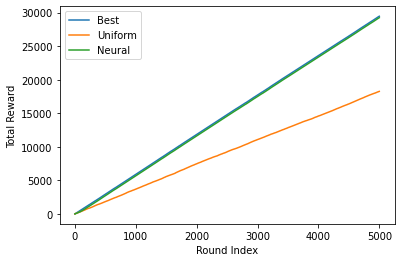

In [5]:
# plot the ratio of cumulated reward
import matplotlib.pyplot as plt
h_r_b = bestagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_b))

h_r_u = uniformagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_u))

h_r_n = deepcopy(neuralagent.history_reward)
plt.plot(range(0, T), np.cumsum(h_r_n))

plt.legend(["Best", "Uniform", "Neural"])
plt.xlabel("Round Index")
plt.ylabel("Total Reward")

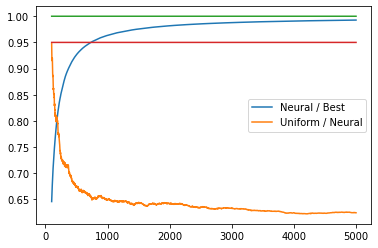

In [6]:
plt.plot(range(100, T), np.cumsum(h_r_n)[100:T] / np.cumsum(h_r_b)[100:T])
plt.plot(range(100, T), np.cumsum(h_r_u)[100:T] / np.cumsum(h_r_n)[100:T])
plt.legend(["Neural / Best", "Uniform / Neural"])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.plot(range(100, T), 0.95 * np.ones(T)[100:T])

Text(0.5, 1.0, 'The ratio of of adopting same decision')

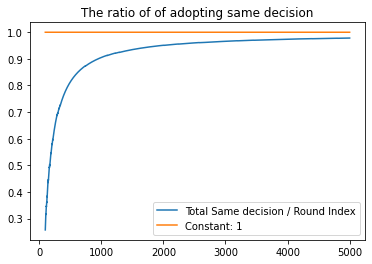

In [7]:
action_match = np.cumsum(neuralagent.history_action == bestagent.history_action)
action_match_ratio = action_match / np.array(range(1, T + 1))
plt.plot(range(100, T), action_match_ratio[100:T])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.legend(["Total Same decision / Round Index", "Constant: 1"])
plt.title("The ratio of of adopting same decision")